In [1]:
import dataset
import models_mae
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torchaudio.transforms as T
import timm.optim.optim_factory as optim_factory
from util.misc import NativeScalerWithGradNormCount as NativeScaler
import time
import datetime
from engine_pretrain import train_one_epoch
import wfdb 
from torchvision.transforms import Resize
import os
import h5py
import pandas as pd


/home/cnelab-workstation/anaconda3/envs/dreamdiffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dir = '/var/lib/transmission-daemon/downloads/training/'

In [3]:
patientName = "tr03-0005"

In [5]:
resize = Resize((64,64), antialias=None)
def spectogram(signal, nfft=128, hop_length=64):
        signal = torch.from_numpy(signal).float()
        spec = torch.stft(signal, nfft, hop_length=hop_length, return_complex=True)
        spec = torch.abs(spec)**2
        spec_db = T.AmplitudeToDB(stype="power", top_db=120)(spec)
        spec_db = resize(spec_db)
        return spec_db

In [6]:
fileList = os.listdir(train_dir)
fileList = [f for f in fileList if f[:2] == 'tr']
len(fileList)

994

In [6]:
channel_names = ['F3-M2','F4-M1','C3-M2','C4-M1','O1-M2','O2-M1']

windowSize = 30
fs = 200
downSampling = 1
numOfChannels = 6
win_size_fs = int(round(windowSize*(fs/float(downSampling))))

# Open eeg data  
record = wfdb.rdsamp(train_dir + '/{}/{}'.format(patientName,patientName) , channel_names=channel_names)


In [ ]:
def generate_specs(patientName, spec_size = (64,64) ):
    record = wfdb.rdsamp(train_dir + '/{}/{}'.format(patientName,patientName) , channel_names=channel_names)
    eeg_signal =  np.float16(record[0])
    eeg_signal = eeg_signal[::downSampling,:]
    n_chuncks = eeg_signal.shape[0]//win_size_fs

    eeg_signal = eeg_signal[:n_chuncks*win_size_fs]

    win_eeg =  np.array(np.array_split(eeg_signal, n_chuncks))
    win_eeg = np.rollaxis(win_eeg, 2, 1)

    win_eeg_combined = win_eeg.reshape((win_eeg.shape[0]*win_eeg.shape[1], win_eeg.shape[2]))
    spec_combined = spectogram(win_eeg_combined)

    spec = spec_combined.reshape((win_eeg.shape[0], win_eeg.shape[1], spec_size[0], spec_size[0]))

    path = "./dataset/physionet/30s_splited/{}".format(patientName) 
    os.mkdir(path)
    for idx, i in enumerate(spec):
        np.save( path + "/{}.{}".format(idx, "npy"), i)

    print("saved ", patientName)
    return patientName

from multiprocessing import Pool 

pool = Pool()

pool.map(generate_specs, fileList) 

In [51]:
generate_specs(patientName)

tr03-0005
saved  tr03-0005


'tr03-0005'

In [8]:
# Open anotation Data 
arousalFile = train_dir + '/{}/{}'.format(patientName,patientName)  + '-arousal.mat'
sleepstages_label = [item for item in h5py.File(arousalFile)['data']['sleep_stages'].keys()]
sleepstages_data = [item[:] for item in h5py.File(arousalFile)['data']['sleep_stages'].values()]

In [9]:
# convert data to one-hot
sleep_stages_onehot = np.concatenate(sleepstages_data).T
sleep_stages_onehot.shape

(5147000, 6)

In [41]:
eeg_signal =  np.float16(record[0])
eeg_signal = eeg_signal[::downSampling,:]
n_chuncks = eeg_signal.shape[0]//win_size_fs

eeg_signal = eeg_signal[:n_chuncks*win_size_fs]
sleep_stages_onehot = sleep_stages_onehot[:n_chuncks*win_size_fs]


In [42]:
win_sleep_stages = np.array(np.array_split(sleep_stages_onehot, n_chuncks))
win_sleep_stages_labels = win_sleep_stages.mean(axis=1).argmax(axis=1)
win_sleep_stages_labels.shape

(857,)

In [43]:
win_eeg =  np.array(np.array_split(eeg_signal, n_chuncks))

win_eeg = np.rollaxis(win_eeg, 2, 1)

print(win_eeg.shape)

(857, 6, 6000)


In [44]:
combined = win_eeg.reshape((win_eeg.shape[0]*win_eeg.shape[1], win_eeg.shape[2]))

In [11]:
spec_combined = spectogram(combined, 128, 64)

spec_combined_splited = spec_combined.reshape((917,6, 65, 94))

NameError: name 'combined' is not defined

In [46]:
spec_combined.shape

torch.Size([5142, 64, 64])

In [47]:
specs_list = []
for i in win_eeg: 
    spec = spectogram(i, 128, 64)
    specs_list.append(spec)
specs = np.stack(specs_list)
specs.shape

(857, 6, 64, 64)

In [80]:
specs[win_sleep_stages_labels == 5].mean(axis=0).shape

(6, 65, 94)

In [49]:
_ = plt.imshow(spec_combined_splited[3].mean(axis=0), aspect="auto", origin="lower")

NameError: name 'spec_combined_splited' is not defined

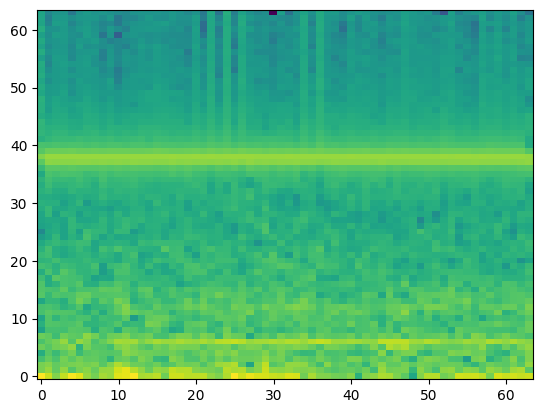

In [52]:
_ = plt.imshow(specs[0][0], aspect="auto", origin="lower")

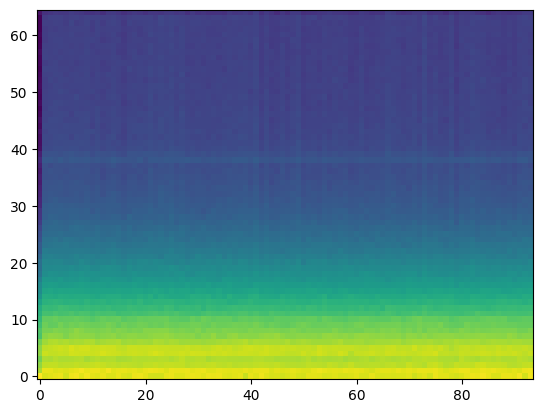

In [82]:
_ = plt.imshow(specs[win_sleep_stages_labels == 0].mean(axis=0)[5], aspect="auto", origin="lower")

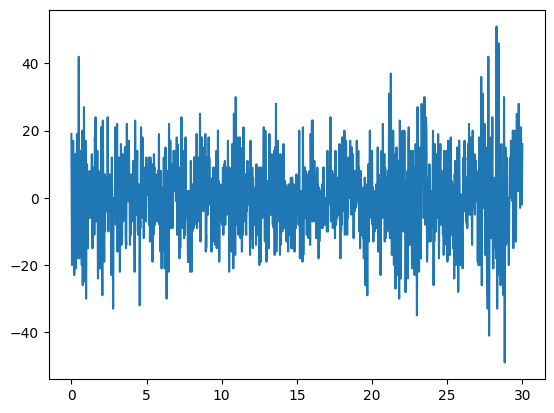

In [113]:
time = np.arange(0, 6000) / fs
plt.plot(time, win_eeg[0,:,0])

In [783]:
specs.squeeze().mean(axis=1).shape

(917, 65, 94)

---

In [4]:
nfft = 128 
hop_length=16 
spec_size=(64,64)
in_chans = 6
eegdataset = dataset.EEGSleepDataset('./dataset/physionet/30s_splited', nfft = nfft, hop_length=hop_length, spec_size=spec_size)

In [5]:
eegdataset.__len__()

65536

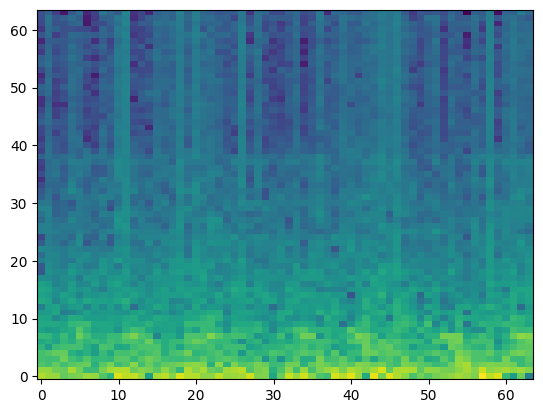

In [6]:
x = eegdataset.__getitem__(0)[0]
t = np.linspace(0, 5, 512)

_ = plt.imshow(x[0], aspect="auto", origin="lower")

In [7]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda')
batch_size = 128
accum_iter = 1
blr = 1e-3
weight_decay = 0.05
epochs = 100

eff_batch_size = batch_size * accum_iter
lr = blr * eff_batch_size / 256

In [8]:
device

device(type='cuda')

In [9]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

args = Namespace(accum_iter=1, mask_ratio=0.8, batch_size=batch_size, lr = blr, warmup_epochs=40, min_lr=0., epochs=epochs)

In [10]:
# DatasetLoader

data_loader_train = torch.utils.data.DataLoader(
        eegdataset, sampler=None,
        batch_size=batch_size,
        num_workers=10,
        pin_memory=True,
        drop_last=True,
    )

In [11]:
mask_2d=False
mask_t_prob=0.5
mask_f_prob=0.3
audio_exp=True

maeeeg = models_mae.maeeg_vit_base_patch4_dec512d8b( in_chans = in_chans, img_size= spec_size, mask_2d=mask_2d,
                                                     mask_t_prob=mask_t_prob, mask_f_prob=mask_f_prob,audio_exp=audio_exp )

maeeeg.to(device)

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed_org(
    (proj): Conv2d(6, 32, kernel_size=(4, 4), stride=(4, 4))
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=32, out_features=96, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=32, out_features=32, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=32, out_features=128, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=128, out_features=32, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_feat

In [12]:
model_without_ddp = maeeeg
print("Model = %s" % str(model_without_ddp))

print("base lr: %.2e" % (lr * 256 / eff_batch_size))
print("actual lr: %.2e" % lr)

print("accumulate grad iterations: %d" % accum_iter)
print("effective batch size: %d" % eff_batch_size)


param_groups = optim_factory.add_weight_decay(model_without_ddp, weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=lr, betas=(0.9, 0.95))
print(optimizer)
loss_scaler = NativeScaler()

Model = MaskedAutoencoderViT(
  (patch_embed): PatchEmbed_org(
    (proj): Conv2d(6, 32, kernel_size=(4, 4), stride=(4, 4))
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=32, out_features=96, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=32, out_features=32, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=32, out_features=128, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=128, out_features=32, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear

In [13]:
maeeeg.decoder_mode = 1

In [14]:
args.mask_ratio

0.8

In [ ]:
maeeeg.to(device)
print(f"Start training for {epochs} epochs")
start_time = time.time()
for epoch in range(0, epochs):
    train_stats = train_one_epoch(
        maeeeg, data_loader_train,
        optimizer, device, epoch, loss_scaler,
        log_writer=None,
        args=args
    )
    # if args.output_dir and (epoch % args.save_every_epoch == 0 or epoch + 1 == args.epochs):
    #     misc.save_model(
    #         args=args, model=model, model_without_ddp=model_without_ddp, optimizer=optimizer,
    #         loss_scaler=loss_scaler, epoch=epoch)

    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                    'epoch': epoch,}

    # if args.output_dir and misc.is_main_process():
    #     if log_writer is not None:
    #         log_writer.flush()
    #     with open(os.path.join(args.output_dir, "log.txt"), mode="a", encoding="utf-8") as f:
    #         f.write(json.dumps(log_stats) + "\n")

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))


In [17]:
def unpatchify(x, c=1):
    """
    x: (N, L, patch_size**2 *3)
    specs: (N, 1, H, W)
    """
    p = 4 
    h = 64//p
    w = 64//p
    x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
    x = torch.einsum('nhwpqc->nchpwq', x)
    specs = x.reshape(shape=(x.shape[0], c, h * p, w * p))
    return specs

def predict(model, x, n_channels=6, mask_ratio = 0.6):
    model.to('cpu')
    loss, y, mask_, _ = model(x, mask_ratio)

    y = unpatchify(y, n_channels)
    y = torch.einsum('nchw->nhwc', y).detach().cpu().squeeze()

    return y, mask_, loss

def get_masks(model, x, n_channels=6, mask_ratio = 0.6):
    y, mask_, loss = predict(model, x, n_channels, mask_ratio)
    mask = mask_.detach()
    #mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = mask.unsqueeze(-1).repeat(1, 1, maeeeg.patch_embed.patch_size[0]**2 *6)
    print(mask.shape)
    mask = unpatchify(mask,6)  # 0 is keep, 1 is remove
    print(mask.shape)
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    print(mask.shape)

    x_ = torch.einsum('nchw->nhwc', x)
    # masked image
    im_masked = x_ * ( 1 - mask) 

    im_reconst=  y * mask + x_ * ( 1 - mask) 

    im_masked2 = im_masked + (1 - mask)

    return im_reconst, im_masked, y, loss


In [39]:
x = eegdataset.__getitem__(0)[0]
x.shape

torch.Size([6, 64, 64])

In [119]:
im_reconst, im_masked, y, loss = get_masks(maeeeg, x.unsqueeze(0), 6, 0.7)
print(loss)

torch.Size([1, 256, 96])
torch.Size([1, 6, 64, 64])
torch.Size([1, 64, 64, 6])
tensor(13.7817, grad_fn=<DivBackward0>)


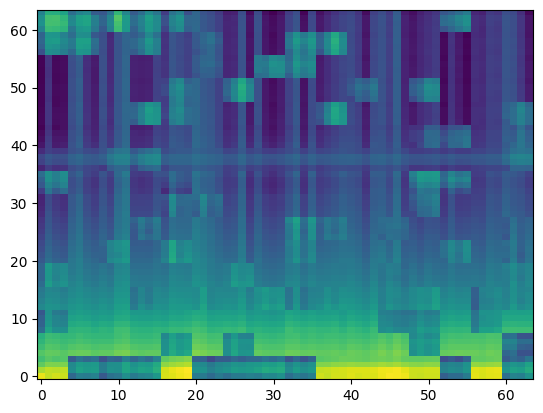

In [126]:

plt.imshow(y[:,:,2], aspect="auto", origin="lower")

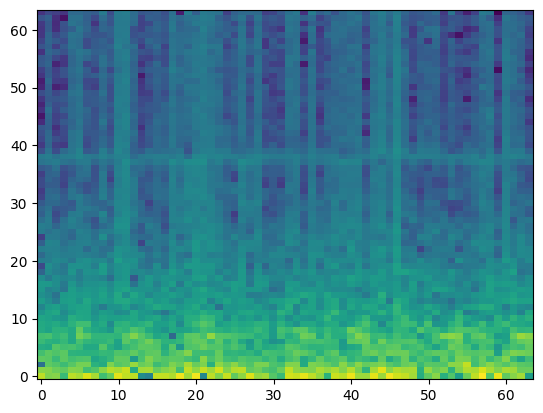

In [125]:
plt.imshow(x[2], aspect="auto", origin="lower")

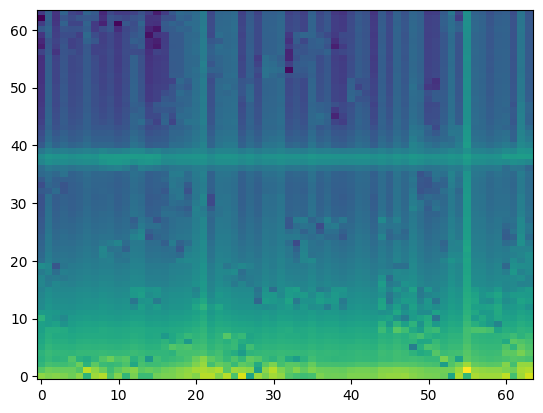

In [124]:
plt.imshow(im_reconst.squeeze()[:,:,3], aspect="auto", origin="lower")

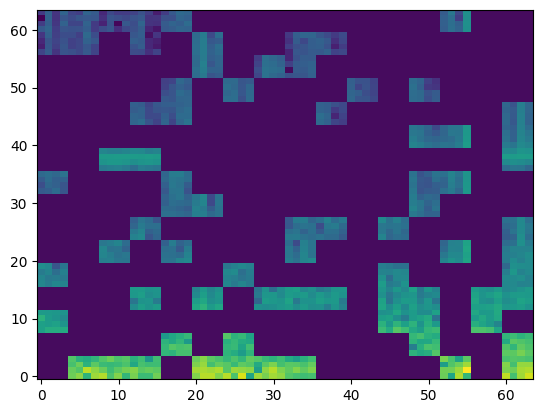

In [123]:
plt.imshow(im_masked.squeeze()[:,:,3], aspect="auto", origin="lower")

In [73]:
checkpoint = torch.load('results/checkpoint-29.pth', map_location='cpu')

model = getattr(models_mae, 'maeeg_vit_base_patch16')(in_chans = in_chans, img_size= spec_size, mask_2d=mask_2d,
                                                     mask_t_prob=mask_t_prob, mask_f_prob=mask_f_prob,audio_exp=audio_exp, norm_pix_loss=True,
                                                     decoder_mode = 1)
msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)

<All keys matched successfully>


In [23]:
train_size = int(0.8 * len(eegdataset))
test_size = len(eegdataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(eegdataset, [train_size, test_size])

In [24]:
x = eegdataset.__getitem__(32)[0]

In [25]:
x.unsqueeze(0).shape

torch.Size([1, 6, 64, 64])

In [102]:
maeeeg.eval()

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed_org(
    (proj): Conv2d(6, 32, kernel_size=(4, 4), stride=(4, 4))
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=32, out_features=96, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=32, out_features=32, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=32, out_features=128, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=128, out_features=32, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_feat

In [127]:
something = maeeeg.forward_encoder(x.unsqueeze(0), 0.7)

In [128]:
something[0].shape

torch.Size([1, 77, 32])

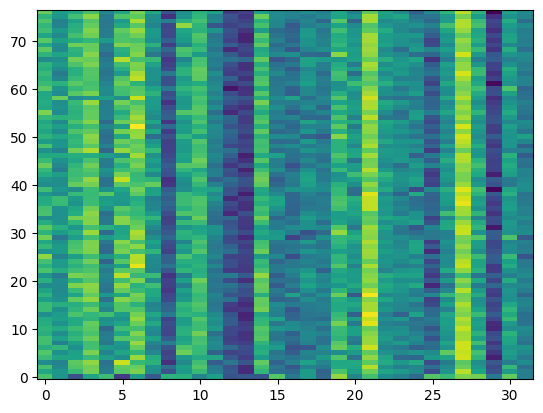

In [170]:
_ = plt.imshow(something[0].detach().numpy().squeeze(), aspect="auto", origin="lower")

In [169]:
temp = something[0].detach().numpy().squeeze()
temp.shape

(77, 32)

In [171]:
np.corrcoef(temp[3], temp[9])

array([[1.       , 0.7717269],
       [0.7717269, 1.       ]])

In [173]:
maeeeg.decoder_embed(something[0]).shape

torch.Size([1, 77, 128])